# *Data Collection*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shapely
import shapely.speedups
from sklearn import linear_model
import geopandas as gpd
import math
import seaborn as sns
from sklearn import preprocessing
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

/home/shrey/.local/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
# Data -- Site 1
dfout_s1 = pd.read_csv('Data/PVData/Site1/PVOut_46834.csv', header=None)
dfout_s1 = dfout_s1.drop(axis=1, columns=[3,4,6,7,8,9,10,11,12,13])
dfout_s1 = dfout_s1.drop(axis=0, index=[item for item in range(32,49+1)])
dfout_s1 = dfout_s1.drop(axis=0, index=[0])
dfout_s1 = dfout_s1.loc[::-1].reset_index(drop=True)

dfsys_s1 = pd.read_csv('Data/PVData/Site1/PVSystem_46834.csv', header=None)

weather_s1 = pd.read_csv('Data/PVData/Site1/NSRDBout_s1.csv', header=None)
weather_s1 = weather_s1.drop(axis=0, index=[0,1,2])
weather_s1 = weather_s1.drop(axis=1, columns=[item for item in range(14,47)])

In [3]:
# Data -- Site 2
dfout_s2 = pd.read_csv('Data/PVData/Site2/PVOut_3445.csv', header=None)
dfout_s2 = dfout_s2.drop(axis=1, columns=[3,4,6,7,8,9,10,11,12,13])
dfout_s2 = dfout_s2.loc[::-1].reset_index(drop=True)

dfsys_s2 = pd.read_csv('Data/PVData/Site2/PVSystem_3445.csv', header=None)

weather_s2 = pd.read_csv('Data/PVData/Site2/NSRDBout_s2.csv', header=None)
weather_s2 = weather_s2.drop(axis=0, index=[0,1,2])
weather_s2 = weather_s2.drop(axis=1, columns=[item for item in range(14,47)])

In [4]:
def outputPanel(systemCapacity,energyGen):
    # We are calculating the output per panel assuming that each panel has a capactiy of 300 Watts
    wattage = 300
    newPanel = systemCapacity/wattage
    outPerPanel = energyGen/newPanel
    
    return float((outPerPanel))

In [5]:
# Returns daily averages for meteorlogical data over the course of a specified month
## also added the energy output to this dataset
# One must specify the MONTH and the NUMBER OF DAYS IN THE MONTH
def daily(weatherData,pvOutData,pvSysData,year,month,numOfDaysMonth):
    
    monthstr = str(month)
    
    # Start of with monthly dataset
    mask = weatherData[2].values == monthstr
    pos = np.flatnonzero(mask)
    monthData = weatherData.iloc[pos]

    dailyData = pd.DataFrame(columns = ['Year','Month','Day','lat','lon','GHI','DHI','DNI',
                                        'Energy Gen',
                                        'Wind Speed','Temperature','Solar Zenith Angle',
                                        'Pressure','Relative Humidity'])    
        
    # Now the Daily Datasets
    for i in range(1, numOfDaysMonth+1):
        # Weather Data
        dayMask = monthData[3].values == str(i)
        pos = np.flatnonzero(dayMask)
        dayData = monthData.iloc[pos]
            
        #PV Data
        gen = outputPanel(pvSysData.iloc[0,1], pvOutData.iloc[(i-1),1])
        
        #PV and Weather Data combined
        df2 = pd.DataFrame([{'Year':year, 'Month':month, 'Day':i, 
                             'lat':pvSysData.iloc[0,13],'lon':pvSysData.iloc[0,14],
                             'Energy Gen':gen, 
                             'GHI':average(dayData,6), 'DHI':average(dayData,7), 
                             'DNI':average(dayData,8), 'Wind Speed':average(dayData,9), 
                             'Temperature':average(dayData,10), 'Solar Zenith Angle':average(dayData,11),
                             'Pressure':average(dayData,12), 'Relative Humidity':average(dayData,13)}])
        
        dailyData = dailyData.append(df2, ignore_index=True)
        
    return dailyData

In [6]:
def average(data, col):
    if col == int:
        col = int(col)
    elif col == str:
        col = str(col)
    co = data[col].tolist()
    intList = [float(item) for item in co]
    avg = sum(intList)/len(intList)
    return avg

In [7]:
dataset_s1  = daily(weather_s1,dfout_s1,dfsys_s1,2020,5,31)
dataset_s2 = daily(weather_s2,dfout_s2,dfsys_s2,2020,6,30)
dataset = dataset_s1.append(dataset_s2, ignore_index=True)

Text(0.5, 1.0, 'Correlation Between Variables')

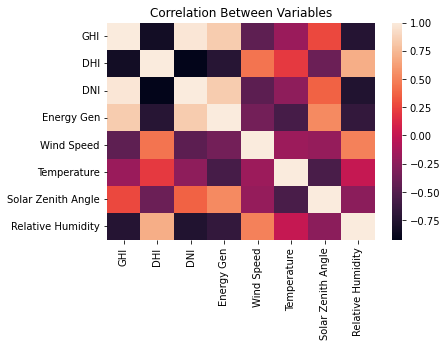

In [8]:
dataVal = dataset.drop(axis=1, columns=['lat','lon','Year','Month','Day','Pressure',])
data_corr = dataVal.corr()
dataplot = sns.heatmap(data_corr)
plt.title('Correlation Between Variables')

### Model 1: Multiple Regression Model

In [9]:
## Normalize Data
NormPre = dataVal.drop(axis=1, columns=['Energy Gen'])
col = NormPre.columns.to_list()

d = preprocessing.normalize(NormPre, axis=0)
scaled_df = pd.DataFrame(d, columns=col)
scaled_df.head()

,GHI,DHI,DNI,Wind Speed,Temperature,Solar Zenith Angle,Relative Humidity
0,0.131077,0.087094,0.142314,0.111897,0.105581,0.133821,0.126190
1,0.138032,0.080770,0.151263,0.120655,0.103464,0.133475,0.126997
2,0.138183,0.083638,0.150012,0.121044,0.100999,0.133137,0.131938
3,0.140569,0.082400,0.153288,0.071031,0.115726,0.132806,0.106145
4,0.140704,0.082856,0.153854,0.069474,0.133836,0.132480,0.083756


In [10]:
# load in variables
x = dataset[['GHI','DNI','Wind Speed']]
y = dataset['Energy Gen']

In [11]:
## Load in regression model
linear_reg = linear_model.LinearRegression()
linear_reg.fit(x,y)

# r^2 value
r2 = linear_reg.score(x,y)
print('r squared: ', r2, '\nVariables: ', x.columns.to_list())

r squared:  0.7181800646348857 
Variables:  ['GHI', 'DNI', 'Wind Speed']


In [12]:
linear_reg.coef_

array([ 2.58338107,  1.35516597, 17.3974214 ])

In [13]:
linear_reg.intercept_

165.16409487008036

### Load in Prediction Data

In [14]:
d1 = pd.read_csv('Data/PredictionData/PredData_1.csv')
d2 = pd.read_csv('Data/PredictionData/PredData_2.csv')
d3 = pd.read_csv('Data/PredictionData/PredData_3.csv')
d4 = pd.read_csv('Data/PredictionData/PredData_4.csv')
d5 = pd.read_csv('Data/PredictionData/PredData_5.csv')
d6 = pd.read_csv('Data/PredictionData/PredData_6.csv')
d7 = pd.read_csv('Data/PredictionData/PredData_7.csv')
d8 = pd.read_csv('Data/PredictionData/PredData_8.csv')
d9 = pd.read_csv('Data/PredictionData/PredData_9.csv')
d10 = pd.read_csv('Data/PredictionData/PredData_10.csv')
d11 = pd.read_csv('Data/PredictionData/PredData_11.csv')
d12 = pd.read_csv('Data/PredictionData/PredData_12.csv')

d1 = d1.append(d2, ignore_index = True)
d1 = d1.append(d3, ignore_index = True)
d1 = d1.append(d4, ignore_index = True)
d1 = d1.append(d5, ignore_index = True)
d1 = d1.append(d6, ignore_index = True)
d1 = d1.append(d7, ignore_index = True)
d1 = d1.append(d8, ignore_index = True)
d1 = d1.append(d9, ignore_index = True)
d1 = d1.append(d10, ignore_index = True)
d1 = d1.append(d11, ignore_index = True)
d1 = d1.append(d12, ignore_index = True)

d1 = d1.drop(axis=1, columns=['Unnamed: 0'])

In [15]:
def PredOut(GHI,DNI,Temp):
    
    #,WindSpeed,Temp,Pressure,Humidity
    
    gen = pd.DataFrame(columns=['lat','lon','Predicted Generation'])

    
    GHI = GHI.to_list()
    DNI = DNI.to_list()
    Temp = Temp.to_list()
    
    lat = d1.lat.to_list()
    lon = d1.lon.to_list()

    for i in range(len(GHI)):

        la = lat[i]
        lo = lon[i]
        x = np.array([[GHI[i],
                       DNI[i],
                       Temp[i]]])
        out = float(linear_reg.predict(x))
        
        gen1 = pd.DataFrame([{'lat':la, 'lon':lo, 'Predicted Generation':out}])
        gen = gen.append(gen1,ignore_index=True)
        
    return gen     

In [16]:
# data = PredOut(d1['GHI'],d1['DHI'],d1['DNI'],d1['Wind Speed'],d1['Temperature'],d1['Pressure'],d1['Relative Humidity'])
data = PredOut(d1['GHI'],d1['DNI'],d1['Temperature'])

In [17]:
data.to_csv('FinalOutData.csv')

In [18]:
data

,lat,lon,Predicted Generation
0,42.796124,-124.474002,1155.817567
1,47.768376,-124.474002,930.559119
2,48.016989,-124.474002,885.180033
3,48.265601,-124.474002,893.603632
4,40.061385,-123.895870,1320.417252
5,40.309997,-123.895870,1281.102712
6,40.558610,-123.895870,1286.316754
7,40.807223,-123.895870,1259.730980
8,41.055835,-123.895870,1245.448988
9,41.304448,-123.895870,1239.502719


In [21]:
maximum = data['Predicted Generation'].idxmax()
maximum

760